## **Importing Libraries**
Importing all the libraries required for reading the datafile, processing the data, required ML models to train and test.

**LabelEncoder** - Onehotencoding the labels, finding unique classes and converting to number representation between 0 to (n-1) unique classes.

In [1]:
# Importing libraries required for handling the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io

# Importing libraries for preprocessing
from sklearn.preprocessing import LabelEncoder

# Importing required clustering algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

## **Uploading and reading the data files provided**

**Uploading the required Datafiles**<br>

*   movies.csv
*   ratings.csv
*   tags.csv



In [2]:
uploaded = files.upload()

Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv
Saving tags.csv to tags.csv


**Reading the uploaded data files**

In [3]:
Mpath = io.BytesIO(uploaded['movies.csv'])
Rpath = io.BytesIO(uploaded['ratings.csv'])
Tpath = io.BytesIO(uploaded['tags.csv'])
df_m = pd.read_csv(Mpath)
df_r = pd.read_csv(Rpath)
df_t = pd.read_csv(Tpath)

In [4]:
df_m.head(3) # Printing the head to see the data in the movies data file

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [5]:
df_r.head(3) # Printing the head to see the data in the ratings data file

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [6]:
df_t.head(3) # Printing the head to see the data in the tags data file

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


## **Cleaning dataset**
Dropping 'timestamp' column as its not a useful feature for our use from both the ratings and tag data sets.

In [7]:
df_r.drop(['timestamp'],axis = 1, inplace=True)
df_t.drop(['timestamp'],axis = 1, inplace=True)

## **Pre-processing the data**
Creating label encoders and using them to fit and transform the features we want to do the one hot encoding on.

* Tag Label - Converting the tag to a unique number
* Title Label - Converting the titles to a unique number
* Genre Label - Not used as it will convert the whole string into label, and I am more interested in all the genres a movie come under as it could be helpfull to find some other movie which will fall under one of the same genre listed.

In [8]:
tagLabel = LabelEncoder()
titleLabel = LabelEncoder()
# genresLabel = LabelEncoder()

**Processing labels for Tag**<br>
using tagLabel encoder to fit and transform the tags in the tag dataset.

In [9]:
df_t['tag'] = tagLabel.fit_transform(df_t["tag"])
df_t.head(3)

,userId,movieId,tag
0,2,60756,936
1,2,60756,231
2,2,60756,1573


**Processing labels for Title**<br>
using titleLabel encoder to fit and transform the title in the movie dataset.

In [10]:
df_m['title'] = titleLabel.fit_transform(df_m['title'])
df_m.head(3)

,movieId,title,genres
0,1,8888,Adventure|Animation|Children|Comedy|Fantasy
1,2,4654,Adventure|Children|Fantasy
2,3,3667,Comedy|Romance


**Processing the genre column**<br>
To prepare the genre column I tried many ways, as it was a string converting the whole string to a unique label didnt help as the encoder was encoding the whole string as one unique label and not many movies will fall under all the same genres. So to use the genre feature more efficiently I tried other ways.

The second way I tried was to create dummy variables of the column, but as
it was a string it was doing it in a similar way as label encoding and created columns for all the possible combination given in the data set. And so this way is commented out in the following cell as it is not helpful.

In [11]:
# df_m['genres'] = df_m['genres'].astype('category')
# df_m = pd.get_dummies(df_m, prefix_sep="_", drop_first= False)
# df_m.head()

The third way I used was to take the whole string and then split it into a list, as the genre list was seperated by a '|', so I splitted it on the '|' and made it into a list of strings this is shown in the execution of the following cell.

In [12]:
df_m['genres'] = df_m['genres'].str.split("|")
df_m.head(3)

,movieId,title,genres
0,1,8888,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,4654,"[Adventure, Children, Fantasy]"
2,3,3667,"[Comedy, Romance]"


After splitting the genres to a list of strings, I had to count all the unique entries in the dataset, which is done using the for loops and a dictionary in the following cell.

In [13]:
gLabel = {}
label = 0
for movie in df_m['genres']:
  for genre in movie:
    if not (genre in gLabel):
      label += 1
      gLabel[genre] = label

After the dictionary was built with every unique genres associated with a number between 1 to n unique classes, again using for loops I replaced all the list of strings to a list of numbers representing the unique genres.

In [14]:
i = 0
for movie in df_m['genres']:
  tmp = []
  for genre in movie:
    tmp.append(gLabel[genre])
  df_m['genres'][i] = tmp
  i += 1 

df_m.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,movieId,title,genres
0,1,8888,"[1, 2, 3, 4, 5]"
1,2,4654,"[1, 3, 5]"
2,3,3667,"[4, 6]"


## **Creating final data set to be used**
Merging the ratings and tag dataset into one, using userId and movieId as keys to join the tables. The method used (how =) is left which says join the other table to the left table (ratings), keeping the ratings data set un changed, this merged all the data points with the same userId and movieId from the tag dataset into the ratings data set. Which means all the tags which existed related to a particular user on a the specific movie were added to the dataset.

Merging the tag dataset and rating dataset reduced the number of total rows as not all users who rated a movie gave a tag with it, adding the feature did add value as it gave us another criteria to cluster the datapoints (movies) together but also reduced the number of total data points for maybe a better clustering. 

In [15]:
new_df = pd.merge(df_r, df_t,  how='left', on=['userId','movieId'])

Printing out the shape and the head of the new merged data frame to see what we need to do next.

Shape of the merged dataset: (102677, 4)<br>
The merged data frame has 102,677 rows (datapoints) and 4 columns (features).

In [16]:
print(new_df.shape)
new_df.head()

(102677, 4)


,userId,movieId,rating,tag
0,1,1,4.0,NaN
1,1,3,4.0,NaN
2,1,6,4.0,NaN
3,1,47,5.0,NaN
4,1,50,5.0,NaN


Dropping the rows with an NaN value in tag as not all users gave a tag for all the movies and so there are many NaN entries which will be noisy for training our ML model.

In [17]:
new_df.dropna(inplace=True)
new_df.reset_index(drop=True)

,userId,movieId,rating,tag
0,2,60756,5.0,936.0
1,2,60756,5.0,231.0
2,2,60756,5.0,1573.0
3,2,89774,5.0,73.0
4,2,89774,5.0,322.0
...,...,...,...,...
3471,606,6107,4.0,565.0
3472,606,7382,4.5,923.0
3473,610,3265,5.0,979.0
3474,610,3265,5.0,996.0


As we can see, after dropping the NaN rows we are only remained with 3,467 rows which is very less than 102,677.

In the following cell we are merging the movies data set to the merged data frame which adds the genres and the title field to our merged dataframe.

In [18]:
new_df = pd.merge(new_df, df_m, how='left', on='movieId')
new_df.head()

,userId,movieId,rating,tag,title,genres
0,2,60756,5.0,936.0,8062,[4]
1,2,60756,5.0,231.0,8062,[4]
2,2,60756,5.0,1573.0,8062,[4]
3,2,89774,5.0,73.0,9294,[7]
4,2,89774,5.0,322.0,9294,[7]


The new shape of the final data frame: (3476, 6)

The data frame still has 3,476 rows but now it has 6 columns (features)

In [19]:
new_df.shape

(3476, 6)

Dropping any NaN rows that might be added after the merge operation. And as we can see after the execution of the following cell that no rows were dropped and so our data set is ready to be used.

In [20]:
new_df.dropna(inplace=True)
new_df.reset_index(drop=True)

,userId,movieId,rating,tag,title,genres
0,2,60756,5.0,936.0,8062,[4]
1,2,60756,5.0,231.0,8062,[4]
2,2,60756,5.0,1573.0,8062,[4]
3,2,89774,5.0,73.0,9294,[7]
4,2,89774,5.0,322.0,9294,[7]
...,...,...,...,...,...,...
3471,606,6107,4.0,565.0,6120,"[7, 14]"
3472,606,7382,4.5,923.0,4218,"[7, 12, 10]"
3473,610,3265,5.0,979.0,3775,"[8, 9, 7, 10]"
3474,610,3265,5.0,996.0,3775,"[8, 9, 7, 10]"


## **Preparing the data**

Once we have all the values processed and in one data frame we now chose the features which will help us with clustering these datapoints.

Features I considered to be good: Rating, Tag, and Genre as these can cluster the movies based on the user rating, its tag and genre.

Features used: After all the processing only 2 features were used, they are rating and tags as genre is a sequence of numbers it could not be used for clustering, future work can include splitting these unique genres into a category type columns with every genre with its own column, and 1 in the row for which ever genre the movie falls under (Dummy variable method shown but not used earlier but using the labeled genres, rather than the strings). 

Using rating and tag together does adds up value to the data set as user ratings are biased towards the user who gave the rating not every person would think that the rating is right, but with using tag which is a unique phrase/word about the movie it clusters the movie to something more common a user can relate to. Merging these data sets does reduce the total number of rows and so reduces the information for maybe a better clusterning model.

In [21]:
df = new_df.sample(frac=1).reset_index(drop=True)
X = (df[['rating','tag']]).values
y = (df['title']).values
print(X.shape)

(3476, 2)


## **Clustering similar data points**
**Clustering models used**
* K means clustering
* DB scan clustering

[0 0 6 ... 3 6 6]


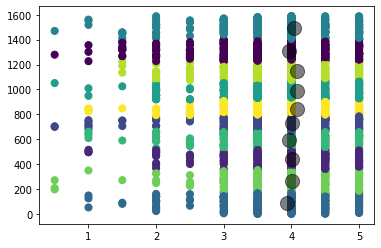

In [22]:
kmeans = KMeans(n_clusters=10).fit(X) # Clustering the data using Kmeans
kmeansPreds = kmeans.predict(X) # Getting the clusters predicted by kmeans
print(kmeans.labels_) # Which data point belongs to which cluster

plt.scatter(X[:, 0], X[:, 1], c=kmeansPreds, s=50) # Plotting how the data is clustered
centers = kmeans.cluster_centers_ # Cluster centers found by kmeans
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5); # Plotting the cluster centers as calculated by kmeans

array([-1,  0,  1, ..., -1, -1, -1])

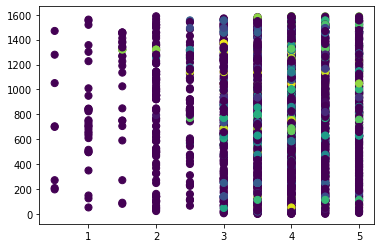

In [23]:
dbScanCluster = DBSCAN().fit(X)
dbScanPreds = DBSCAN().fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=dbScanPreds, s=50)

dbScanCluster.labels_